In [29]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit.circuit.library import RealAmplitudes
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.optimization import *
from qiskit.optimization.converters import *
from qiskit.optimization.algorithms import *
from qiskit.aqua import *
from qiskit.aqua.algorithms import *
from qiskit.aqua.operators import *
from qiskit.aqua.components.optimizers import COBYLA

import matplotlib.pyplot as plt
import numpy as np
from docplex.mp.model import Model
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-02-18 14:34:19,898: Credentials are already in use. The existing account in the session will be replaced.


In [43]:
qp = QuadraticProgram()
c = [1, 1, 1]
t = [1, 2, 1]
w = [1, 2, 3]
D = 5
D_temp = [1, 2, 3]
test = []
s = 1
for i in range(3):
    for j in range(i+1):
        test.append('x'+f'{i+1}{j+1}')
        qp.binary_var('x'+f'{i+1}{j+1}')

qp.maximize(linear={'x11':c[0], 'x21':c[0], 'x22':c[1], "x31":c[0], 'x32':c[1],'x33':c[2]})
qp.linear_constraint(linear={'x11':1, 'x22':1, 'x33':1}, sense='E', rhs=1, name='select_i')
qp.linear_constraint(linear={'x21':1, 'x22':-1}, sense='L', rhs=0, name='x2cons')
qp.linear_constraint(linear={'x31':1, 'x32':1, 'x33':-2}, sense='L', rhs=0, name='x3cons')
qp.linear_constraint(linear={'x11':t[0]+D_temp[0], 'x21':t[0], 'x22':t[1]+D_temp[1], "x31":t[0], 'x32':t[1],'x33':t[2]+D_temp[2]}, sense='LE', rhs=D, name='deadline')
print(qp.export_as_lp_string())


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: x11 + x21 + x22 + x31 + x32 + x33
Subject To
 select_i: x11 + x22 + x33 = 1
 x2cons: x21 - x22 <= 0
 x3cons: x31 + x32 - 2 x33 <= 0
 deadline: 2 x11 + x21 + 4 x22 + x31 + 2 x32 + 4 x33 <= 5

Bounds
 0 <= x11 <= 1
 0 <= x21 <= 1
 0 <= x22 <= 1
 0 <= x31 <= 1
 0 <= x32 <= 1
 0 <= x33 <= 1

Binaries
 x11 x21 x22 x31 x32 x33
End



In [33]:
ineq2eq = InequalityToEquality()
qp_eq = ineq2eq.convert(qp)
print(qp_eq.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: x11 + x21 + 2 x22 + x31 + 2 x32 + x33
Subject To
 select_i: x11 + x22 + x33 = 1
 x2cons: x21 - x22 + x2cons@int_slack = 0
 x3cons: x31 + x32 - 2 x33 + x3cons@int_slack = 0
 deadline: 2 x11 + x21 + 4 x22 + x31 + 2 x32 + 4 x33 + deadline@int_slack = 6

Bounds
 0 <= x11 <= 1
 0 <= x21 <= 1
 0 <= x22 <= 1
 0 <= x31 <= 1
 0 <= x32 <= 1
 0 <= x33 <= 1
       x2cons@int_slack <= 1
       x3cons@int_slack <= 2
       deadline@int_slack <= 6

Binaries
 x11 x21 x22 x31 x32 x33

Generals
 x2cons@int_slack x3cons@int_slack deadline@int_slack
End



In [34]:
int2bin = IntegerToBinary()
qp_eq_bin = int2bin.convert(qp_eq)
print(qp_eq_bin.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: x11 + x21 + 2 x22 + x31 + 2 x32 + x33
Subject To
 select_i: x11 + x22 + x33 = 1
 x2cons: x21 - x22 + x2cons@int_slack@0 = 0
 x3cons: x31 + x32 - 2 x33 + x3cons@int_slack@0 + x3cons@int_slack@1 = 0
 deadline: 2 x11 + x21 + 4 x22 + x31 + 2 x32 + 4 x33 + deadline@int_slack@0
           + 2 deadline@int_slack@1 + 3 deadline@int_slack@2 = 6

Bounds
 0 <= x11 <= 1
 0 <= x21 <= 1
 0 <= x22 <= 1
 0 <= x31 <= 1
 0 <= x32 <= 1
 0 <= x33 <= 1
 0 <= x2cons@int_slack@0 <= 1
 0 <= x3cons@int_slack@0 <= 1
 0 <= x3cons@int_slack@1 <= 1
 0 <= deadline@int_slack@0 <= 1
 0 <= deadline@int_slack@1 <= 1
 0 <= deadline@int_slack@2 <= 1

Binaries
 x11 x21 x22 x31 x32 x33 x2cons@int_slack@0 x3cons@int_slack@0
 x3cons@int_slack@1 deadline@int_slack@0 deadline@int_slack@1
 deadline@int_slack@2
End



In [35]:
lineq2penalty = LinearEqualityToPenalty()
qubo = lineq2penalty.convert(qp_eq_bin)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Maximize
 obj: 235 x11 + 109 x21 + 452 x22 + 109 x31 + 218 x32 + 451 x33
      + 108 deadline@int_slack@0 + 216 deadline@int_slack@1
      + 324 deadline@int_slack@2 + [ - 90 x11^2 - 72 x11*x21 - 324 x11*x22
      - 72 x11*x31 - 144 x11*x32 - 324 x11*x33 - 72 x11*deadline@int_slack@0
      - 144 x11*deadline@int_slack@1 - 216 x11*deadline@int_slack@2 - 36 x21^2
      - 108 x21*x22 - 36 x21*x31 - 72 x21*x32 - 144 x21*x33
      - 36 x21*x2cons@int_slack@0 - 36 x21*deadline@int_slack@0
      - 72 x21*deadline@int_slack@1 - 108 x21*deadline@int_slack@2 - 324 x22^2
      - 144 x22*x31 - 288 x22*x32 - 612 x22*x33 + 36 x22*x2cons@int_slack@0
      - 144 x22*deadline@int_slack@0 - 288 x22*deadline@int_slack@1
      - 432 x22*deadline@int_slack@2 - 36 x31^2 - 108 x31*x32 - 72 x31*x33
      - 36 x31*x3cons@int_slack@0 - 36 x31*x3cons@int_slack@1
      - 36 x31*deadline@int_slack@0 - 72 x31*deadline@int_slack@1


In [44]:
op, offset = qubo.to_ising()
print('offset: {}'.format(offset))
print('operator:')
print(op)

offset: 311.0
operator:
SummedOp([
  -76.0 * IIIIIIIIIIIZ,
  -40.0 * IIIIIIIIIIZI,
  -143.0 * IIIIIIIIIZII,
  -44.5 * IIIIIIIIZIII,
  -80.0 * IIIIIIIZIIII,
  -130.0 * IIIIIIZIIIII,
  -36.0 * IIZIIIIIIIII,
  -72.0 * IZIIIIIIIIII,
  -108.0 * ZIIIIIIIIIII,
  9.0 * IIIIIIIIIIZZ,
  40.5 * IIIIIIIIIZIZ,
  13.5 * IIIIIIIIIZZI,
  9.0 * IIIIIIIIZIIZ,
  4.5 * IIIIIIIIZIZI,
  18.0 * IIIIIIIIZZII,
  18.0 * IIIIIIIZIIIZ,
  9.0 * IIIIIIIZIIZI,
  36.0 * IIIIIIIZIZII,
  13.5 * IIIIIIIZZIII,
  40.5 * IIIIIIZIIIIZ,
  18.0 * IIIIIIZIIIZI,
  76.5 * IIIIIIZIIZII,
  9.0 * IIIIIIZIZIII,
  27.0 * IIIIIIZZIIII,
  4.5 * IIIIIZIIIIZI,
  -4.5 * IIIIIZIIIIII,
  -4.5 * IIIIIZIIIZII,
  4.5 * IIIIZIIIZIII,
  -9.0 * IIIIZIIIIIII,
  4.5 * IIIIZIIZIIII,
  -9.0 * IIIIZIZIIIII,
  4.5 * IIIZIIIIZIII,
  -9.0 * IIIZIIIIIIII,
  4.5 * IIIZIIIZIIII,
  -9.0 * IIIZIIZIIIII,
  4.5 * IIIZZIIIIIII,
  9.0 * IIZIIIIIIIIZ,
  4.5 * IIZIIIIIIIZI,
  18.0 * IIZIIIIIIZII,
  4.5 * IIZIIIIIZIII,
  9.0 * IIZIIIIZIIII,
  18.0 * IIZIIIZIIIII,
  

In [37]:
aqua_globals.random_seed = 10598
quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'), 
                                  seed_simulator=aqua_globals.random_seed, 
                                  seed_transpiler=aqua_globals.random_seed)

qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 0.])
exact_mes = NumPyMinimumEigensolver()

In [48]:

maxiter = 80
optimizer = COBYLA(maxiter=maxiter)

var_form = RealAmplitudes(op.num_qubits, reps=1)
m = var_form.num_parameters

backend_name = 'qasm_simulator'
backend = Aer.get_backend(backend_name)

alphas = [0.50, 0.25, 0.125]

In [49]:

objectives = {alpha: [] for alpha in alphas}
results = {}

def callback(i, params, obj, stddev, alpha):
    objectives[alpha] += [-(obj + offset)]

for alpha in alphas:
    
    cvar_exp = CVaRExpectation(alpha, PauliExpectation())
    cvar_exp.compute_variance = lambda x: [0]
    
    vqe = VQE(expectation=cvar_exp, optimizer=optimizer, var_form=var_form,
              quantum_instance=backend, callback=lambda i, params, obj, stddev: callback(i, params, obj, stddev, alpha))
    
    opt_alg = MinimumEigenOptimizer(vqe)
    
    results[alpha] = opt_alg.solve(qubo)
    
    print(f'alpha = {alpha}')
    print(results[alpha])
    print()

alpha = 0.5
optimal function value: -5.0
optimal value: [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
status: SUCCESS

alpha = 0.25
optimal function value: -5.0
optimal value: [0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
status: SUCCESS

alpha = 0.125
optimal function value: 2.0
optimal value: [0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0.]
status: SUCCESS



In [50]:
qaoa = MinimumEigenOptimizer(qaoa_mes)
exact = MinimumEigenOptimizer(exact_mes)
qaoa_result = qaoa.solve(qubo)
exact_result = exact.solve(qubo)
print(exact_result)
print(qaoa_result)

optimal function value: 3.0
optimal value: [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
status: SUCCESS
optimal function value: 2.0
optimal value: [0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
status: SUCCESS


In [51]:
rqaoa = RecursiveMinimumEigenOptimizer(min_eigen_optimizer=qaoa, min_num_vars=3, min_num_vars_optimizer=exact)
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result)
#why?

optimal function value: -15.0
optimal value: [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
status: SUCCESS


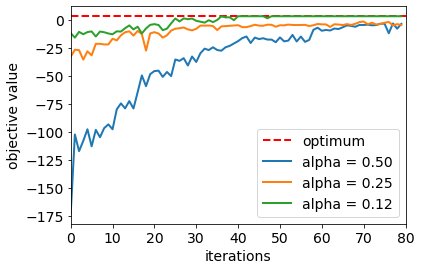

In [52]:

plt.plot([0, maxiter], [exact_result.fval, exact_result.fval], 'r--', linewidth=2, label='optimum')
for alpha in alphas:
    plt.plot(objectives[alpha], label='alpha = %.2f' % alpha, linewidth=2)
plt.legend(loc='lower right', fontsize=14)
plt.xlim(0, maxiter)
plt.xticks(fontsize=14)
plt.xlabel('iterations', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('objective value', fontsize=14)
plt.show()